In [1]:
# Importo las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# Librerías Sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor as KN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime as dt
# Librerías para el mapa interactivo
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
import webbrowser
from folium import plugins
from folium.plugins import HeatMap
# Importamos librerias de Clustering
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn import metrics

Solving environment: done

# All requested packages already installed.



# Machine Learning

In [2]:
Delitos_full = pd.read_excel('Delitos_full.xlsx')

## Clusterización

In [3]:
clusters = Delitos_full
clusters.Comuna = clusters.Comuna.astype(int)
np.shape(clusters)

(480134, 13)

Aplicamos label encoder para transformar los valores categóricos en numéricos

In [4]:
le = preprocessing.LabelEncoder()
clusters.Tipo =le.fit_transform(clusters.Tipo)
clusters.Tipo.unique()

array([3, 2, 1, 0])

### Ranking de los 10 barrios mas peligrosos

In [5]:
top_n = 10
idx_top = Delitos_full ['Barrio'].value_counts(ascending=False).index[0:top_n]
barrios_peligrosos = list(idx_top)

### Dummies de los barrios para poder trabajar con el modelo

In [6]:
clusters = clusters.loc[clusters.Barrio.isin(barrios_peligrosos)]
clusters_dummies = pd.get_dummies(clusters.Barrio)
clusters_dummies.head()

,Almagro,Balvanera,Barracas,Belgrano,Caballito,Flores,Palermo,Recoleta,San Nicolás,Villa Lugano
1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0
7,0,0,1,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0


In [7]:
x = pd.concat([clusters,clusters_dummies], axis=1)
x.drop(['Barrio'], inplace = True, axis = 1)
np.shape(x)

(230624, 22)

### Trabajaremos con los años 2018 y 2019

In [8]:
lista = [2018,2019]
x = x.loc[x.Año.isin(lista)]
np.shape(x)

(114111, 22)

### Autoscaling

In [9]:
scaler = preprocessing.StandardScaler().fit(x)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
xscal = scaler.transform(x)  

### Principal component analysis (PCA)
Generamos un PCA con los datos luego del autoscaling

In [11]:
n_comps = 10 # 10 Principales componentes
sklearn_pca = sklearnPCA(n_components= n_comps)
xpca = pd.DataFrame(sklearn_pca.fit_transform(xscal))
eigenvalues = sklearn_pca.explained_variance_ratio_
eigenvalues

array([0.18712788, 0.11856086, 0.09023226, 0.06008482, 0.05981791,
       0.05446903, 0.05179998, 0.05061814, 0.04993168, 0.04970089])

### Visualizamos las 10 primeras componentes y la varianza explicada por cada una

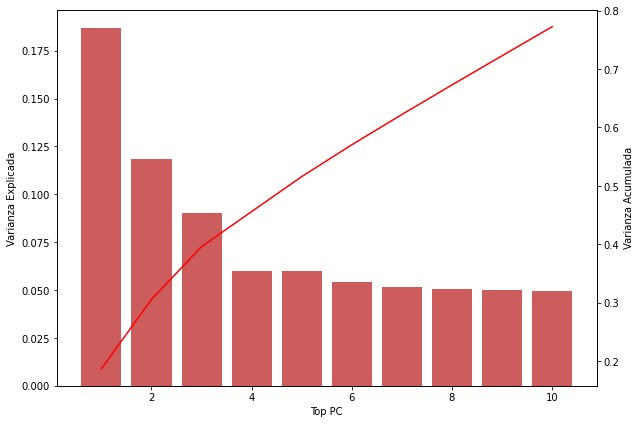

In [12]:
# Suma acumulada
diverging_colors = sns.color_palette("Reds_r", 20)
eigenvalues_acum = sklearn_pca.explained_variance_ratio_.cumsum() 
components = range(1,n_comps + 1)
# Graficamos
# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(9,6))
ax1.set_xlabel('Top PC')
ax1.set_ylabel('Varianza Explicada', color='k')
ax1.bar(components, eigenvalues, color = 'indianred')
ax1.tick_params(axis='y')

# Eje derecho
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='k') 
ax2.plot(components, eigenvalues_acum, color='r') 
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [13]:
print('Varianza explicada por las 10 primeras componentes principales:',sklearn_pca.explained_variance_ratio_.sum())

Varianza explicada por las 10 primeras componentes principales: 0.7723434413308917


### Scatterplot de los datos con PC1 y PC2

No handles with labels found to put in legend.


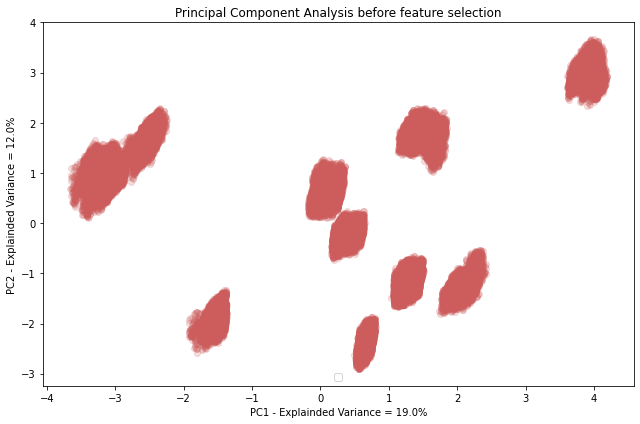

In [14]:
# scatter plot de los datos solamente con las 2 primeras componentes principales de los datos
plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[:,0],xpca.loc[:,1], c = 'indianred' ,alpha = 0.2)    
plt.xlabel('PC1 - Explainded Variance = ' + str(np.round(eigenvalues[0],2)*100) + '%')
plt.ylabel('PC2 - Explainded Variance = ' + str(np.round(eigenvalues[1],2)*100)+ '%')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

### Algoritmo Kmeans

In [15]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(xpca)
kmeans.labels_

array([1, 1, 3, ..., 1, 0, 1], dtype=int32)

In [16]:
kmeans.cluster_centers_

array([[ 0.9244348 , -0.53655974, -0.05946364,  0.09551829,  0.22044258,
        -0.65636895, -0.3264559 , -0.63824138, -0.14266854,  0.49676731],
       [ 2.4339378 ,  2.25062383,  0.08361187, -0.41799632, -0.37026243,
         0.42607264,  0.10359037,  1.04932943, -0.22603439, -0.24184119],
       [-0.41159677, -2.16873155, -0.20107564, -0.69423472, -0.49172781,
         0.93278148,  0.36712509,  0.31845094,  0.2199646 , -0.60194699],
       [-2.96214436,  1.17851685,  0.21588793,  0.74507753,  0.32232432,
        -0.00860035,  0.1582643 ,  0.04725129,  0.21283361, -0.14235715]])

#### Muestras por cluster

/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


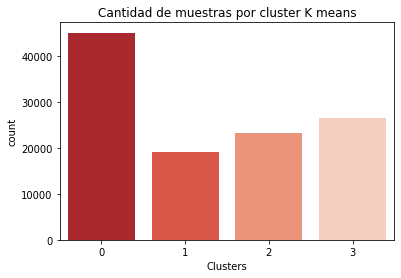

In [17]:
diverging_colors = sns.color_palette("Reds_r", 4)
sns.countplot(kmeans.labels_, palette = diverging_colors)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

### EDA por cluster

In [18]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = x.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map = cluster_map.set_index('data_index')
x_clusterizado = x.merge(cluster_map, left_on = x.index, right_on = cluster_map.index)
x_clusterizado.Precio_m2 = round(x_clusterizado.Precio_m2,1) 
x_clusterizado.head()

,key_0,Unnamed: 0,Dia,Mes,Año,Hora,Tipo,Cantidad,Comuna,Latitud,...,Balvanera,Barracas,Belgrano,Caballito,Flores,Palermo,Recoleta,San Nicolás,Villa Lugano,cluster
0,244659,244681,1,1,2018,20,1,1,8,-34.669643,...,0,0,0,0,0,0,0,0,1,1
1,244660,244682,1,1,2018,14,1,1,8,-34.680992,...,0,0,0,0,0,0,0,0,1,1
2,244661,244683,1,1,2018,11,3,1,13,-34.571114,...,0,0,1,0,0,0,0,0,0,3
3,244662,244684,1,1,2018,22,1,1,4,-34.646857,...,0,1,0,0,0,0,0,0,0,0
4,244665,244687,1,1,2018,15,1,1,1,-34.603694,...,0,0,0,0,0,0,0,1,0,2


In [19]:
cluster_0 = x_clusterizado.loc[x_clusterizado.cluster == 0]
cluster_1 = x_clusterizado.loc[x_clusterizado.cluster == 1]
cluster_2 = x_clusterizado.loc[x_clusterizado.cluster == 2]
cluster_3 = x_clusterizado.loc[x_clusterizado.cluster == 3]
print(np.shape(cluster_0), np.shape(cluster_1), np.shape(cluster_2), np.shape(cluster_3))

(45097, 24) (19186, 24) (23215, 24) (26613, 24)


/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

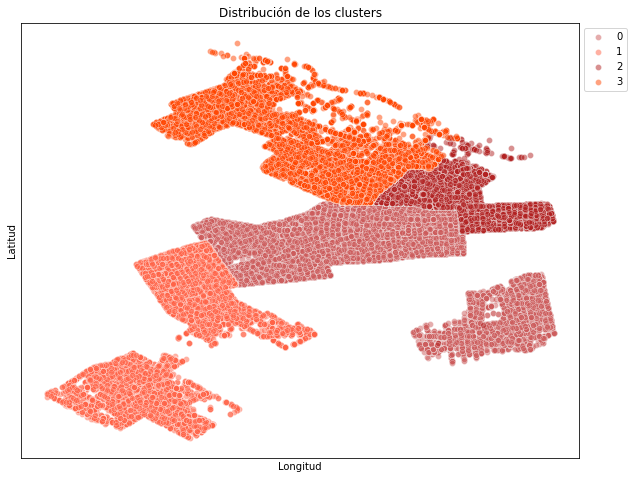

In [20]:
plt.figure(figsize = (10,8))
sns.scatterplot(cluster_0.Longitud,cluster_0.Latitud, alpha=0.5, color = 'indianred')
sns.scatterplot(cluster_1.Longitud,cluster_1.Latitud, alpha=0.5, color = 'tomato')
sns.scatterplot(cluster_2.Longitud,cluster_2.Latitud, alpha=0.5, color = 'firebrick')
sns.scatterplot(cluster_3.Longitud,cluster_3.Latitud, alpha=0.5, color = 'orangered')
plt.title('Distribución de los clusters')
plt.legend(labels = xpca ,loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.show()

#### Nuevo PCA coloreando los clusters generados

In [21]:
n_comps = 10
sklearn_pca = sklearnPCA(n_components= n_comps)
xpca = pd.DataFrame(sklearn_pca.fit_transform(xscal))
eigenvalues = sklearn_pca.explained_variance_ratio_

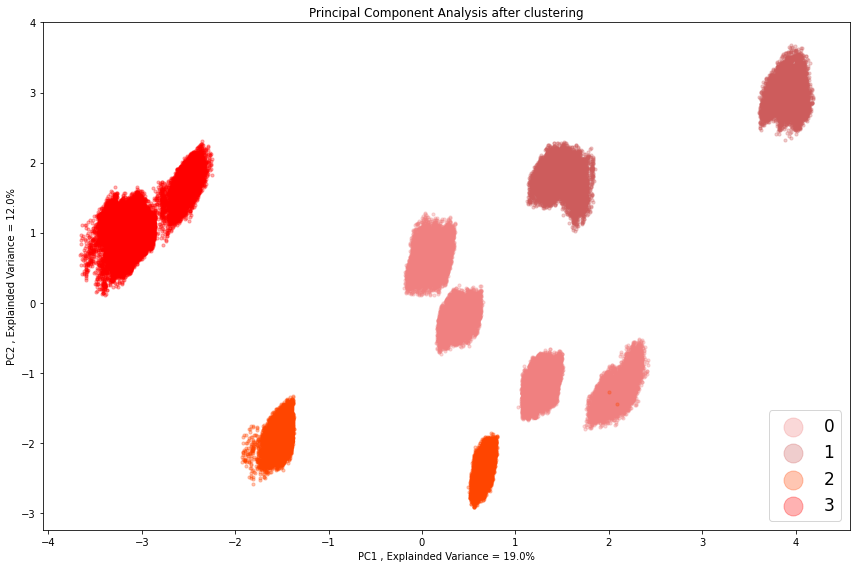

In [22]:
plt.figure(figsize = (12,8))
plt.scatter(x = xpca.iloc[kmeans.labels_==0,0], y = xpca.iloc[kmeans.labels_==0,1], alpha = 0.3, s = 10, c = 'lightcoral')
plt.scatter(x = xpca.iloc[kmeans.labels_==1,0], y = xpca.iloc[kmeans.labels_==1,1], alpha = 0.3, s = 10, c = 'indianred')
plt.scatter(x = xpca.iloc[kmeans.labels_==2,0], y = xpca.iloc[kmeans.labels_==2,1], alpha = 0.3, s = 10, c = 'orangered')
plt.scatter(x = xpca.iloc[kmeans.labels_==3,0], y = xpca.iloc[kmeans.labels_==3,1], alpha = 0.3, s = 10, c = 'red')
plt.xlabel('PC1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)*100) + '%')
plt.ylabel('PC2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)*100) + '%')
plt.title('Principal Component Analysis after clustering')
plt.legend(labels = xpca ,loc='lower right', fontsize = 17, markerscale = 6 )
plt.tight_layout()
plt.show()

#### Silhouette Index
Mide cuán similar es una muestra respecto a su propio cluster (cohesión) comparado con el resto de los clusters (separación)

In [23]:
metrics.silhouette_score(xpca, kmeans.labels_, metric='euclidean')

0.30680796283006734

## Clasificación


#### Ranking de los 5 barrios con mas delitos para realizar la clasificación
#### Predicción del tipo de delito en función de las features con las que contamos

In [24]:
top = 5
Barrios_top = Delitos_full ['Barrio'].value_counts(ascending=False).index[0:top]
Delitos_Barrios_top = Delitos_full[Delitos_full.Barrio.isin(Barrios_top)]

#### Label encoder
Para codificar los tipos de delitos

In [25]:

# "le" es el label encoder que transforma las etiquetas de string a INT.
le = preprocessing.LabelEncoder()
Delitos_Barrios_top.Tipo =le.fit_transform(Delitos_Barrios_top.Tipo)


/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Dummies para los barrios

In [26]:
Barrio_dummie = pd.get_dummies(Delitos_Barrios_top.Barrio)
Delitos_Barrios_top= Delitos_Barrios_top.join([Barrio_dummie])

#### Filtramos solo 2019 y dropeamos las features que no nos interesan

In [27]:
Delitos=Delitos_Barrios_top.loc[Delitos_Barrios_top.Año == 2019]
Delitos= Delitos.drop(['Barrio','Año','Cantidad'], axis=1)
Delitos.Comuna =Delitos.Comuna.astype(int) 

Creamos dataset con el top 10 de barrios mas peligrosos como dummies

#### Obtenemos las features y target

In [29]:
x=Delitos
x = x.drop(['Tipo'], axis=1)
y=Delitos.Tipo
x.shape,y.shape

((36150, 14), (36150,))

#### Separamos en train y test

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.8, random_state=8)
xtrain.shape

(7230, 14)

#### Realizamos el autoscaling, fiteandolo con xtrain

In [31]:
scaler = preprocessing.StandardScaler().fit(xtrain)
xtrain_scal = scaler.transform(xtrain) 
xtest_scal = scaler.transform(xtest)  

### Clasificación multiclase con KNeighbors

#### GridSearch y CV

In [32]:
# DEfino el estimador para el svr
clf = KNeighborsClassifier()
# Determino los parametros del modelo
parameters_k = np.arange(1,20,1)
parameters_knn = [{'n_neighbors': parameters_k}]
n_folds=5
# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(clf, param_grid=parameters_knn,refit=True,
                  cv=n_folds, scoring="accuracy",
                  verbose=3, n_jobs = 3)

In [33]:
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done  95 out of  95 | elapsed:    6.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=3,
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [34]:
#muestro los mejores resultados del GS
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform') 

{'n_neighbors': 19} 

0.5609958506224066 



#### Predicción 

In [35]:
KNN_prediction = gs.best_estimator_.predict(xtest_scal)

#### Accuracy

In [36]:
KNN_accuracy = accuracy_score(y_true = ytest, y_pred = KNN_prediction)
KNN_accuracy

0.5549792531120332

#### Matriz de confusión para la clasificación multiclase

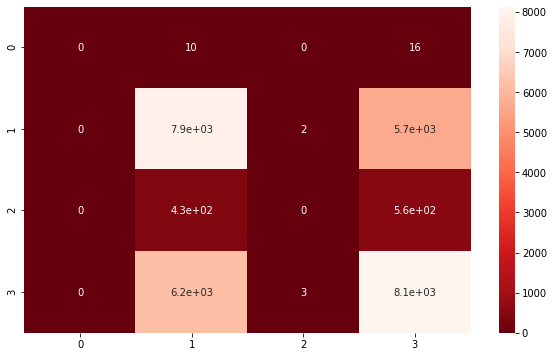

In [37]:
cm = confusion_matrix(ytest, KNN_prediction)
cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],columns = [i for i in np.unique(y)])
plt.figure(figsize = (10,6))
sns.heatmap(cm, annot=True, cmap="Reds_r")
plt.show()

### Clasificación con SVM

#### GridSeach y CrossValidation 

In [38]:
clf = SVC()
# Parametros seleccionados
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf','linear']}  
  
gs = GridSearchCV(clf, param_grid, refit = True, verbose = 3) 
  
# fiteamos el modelo
gs.fit(xtrain_scal, ytrain) 

/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.561, total=   1.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.554, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.549, total=   1.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.541, total=   0.9s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.538, total=   0.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.535, total=   0.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.551, total=   1.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.543, total=   1.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.552, total=   1.3s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

#### Mostramos los hiperparámetros que dieron el mejor resultado

In [39]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} 

0.5813278008298756 



#### Predicción y computo del accuracy

In [40]:
SVM_prediction = gs.best_estimator_.predict(xtest_scal)
SVM_accuracy = accuracy_score(y_true = ytest, y_pred = SVM_prediction)

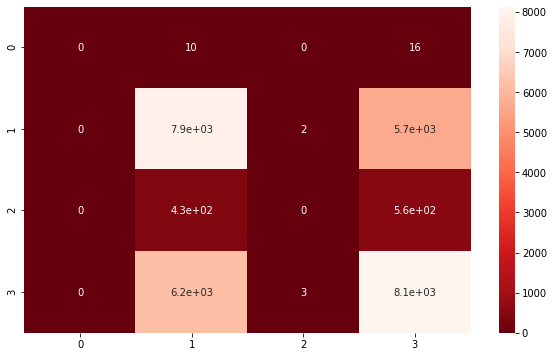

In [41]:
#ploteo la matriz
cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],columns = [i for i in np.unique(y)])
plt.figure(figsize = (10,6))
sns.heatmap(cm, annot=True, cmap="Reds_r")
plt.show()

#### Matriz de confusión para SVM

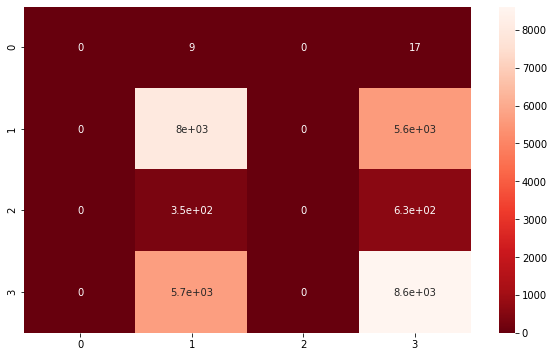

In [42]:
cm = confusion_matrix(ytest, SVM_prediction)
cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],columns = [i for i in np.unique(y)])
plt.figure(figsize = (10,6))
sns.heatmap(cm, annot=True, cmap="Reds_r")
plt.show()

### Clasificación con Logistic Regression

#### GridSeach y CrossValidation 

In [43]:
lr = LogisticRegression(random_state=0)
# Parametros seleccionados
param_grid = {'C': [0.1, 1, 100]}  
  
gs = GridSearchCV(lr, param_grid, refit = True, verbose = 3) 
  
# fiteamos el modelo
gs.fit(xtrain_scal, ytrain) 

/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/line

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.544, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.547, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.548, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.544, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.543, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.547, total=   0.0s
[CV] C=100 ...........................................................
[CV] .............

/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/federicogirola/

[CV] ............................... C=100, score=0.547, total=   0.1s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/federicogirola/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [44]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

{'C': 0.1} 

0.5461964038727524 



#### Predicción y accuracy con logistic regression

In [45]:
lr_prediction = gs.best_estimator_.predict(xtest_scal)
lr_accuracy = accuracy_score(y_true = ytest, y_pred = lr_prediction)

#### Matriz de confusión para logistic regression

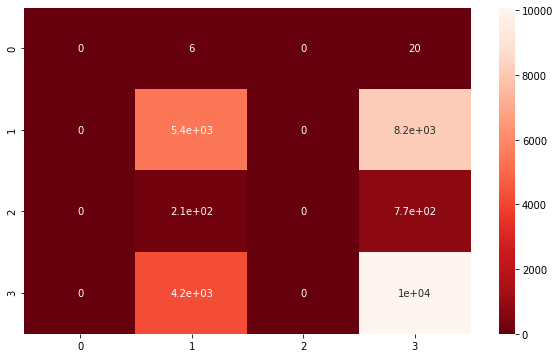

In [46]:
cm = confusion_matrix(ytest, lr_prediction)
cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],columns = [i for i in np.unique(y)])
plt.figure(figsize = (10,6))
sns.heatmap(cm, annot=True, cmap="Reds_r")
plt.show()

#### Comparación de los resultados de ambos modelos de clasificación

In [47]:
results_df = pd.DataFrame(columns=['Model','Kernel','Accuracy'])
results_df = results_df.append({'Model':'KNN','Kernel':'','Accuracy': round(KNN_accuracy*100,2)}, ignore_index = True)
results_df = results_df.append({'Model':'SVM','Kernel':'rbf','Accuracy': round(SVM_accuracy*100,2)}, ignore_index = True)
results_df = results_df.append({'Model':'LR','Kernel':'','Accuracy': round(lr_accuracy*100,2)}, ignore_index = True)
results_df

,Model,Kernel,Accuracy
0,KNN,,55.5
1,SVM,rbf,57.4
2,LR,,53.7
